In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import numpy as np

import cv2

from fastai import *
from fastai.vision import *
from fastai.vision import learner
from fastai.callbacks import *

## setup paths and train.csv

In [3]:
path = Path('data')

In [4]:
df = pd.read_csv(path/'train.csv')

In [5]:
df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
#count = len(os.listdir(path/'train'))
avg_width = 0
avg_height = 0
for idx, fn in enumerate(os.listdir(path/'train')[:1000]):
    img = cv2.imread(os.path.join(path/'train',fn))
    avg_width += img.shape[1]
    avg_height += img.shape[0]
avg_width //= 1000
avg_height //= 1000
print(avg_width, avg_height)

991 508


In [7]:
## Filtering classes with atleast 60 images for quick experiments
counter = Counter(df.Id.values)
df['cnt']=df['Id'].apply(lambda x: counter[x])
#Not consider new_whale images and hence considering 500 as upper cutoff
df = df[(df['cnt']>60) & (df['cnt']<500)] 

In [8]:
len(df)

261

In [9]:
df['target'] = 1
df1 = df.copy()
df1['target'] = 0
df = df.append(df1)
target_col = 3

In [10]:
mean, std = torch.tensor(imagenet_stats)

In [11]:
class SiamImage(ItemBase):
    def __init__(self, img1, img2): ## These should of Image type
        self.img1, self.img2 = img1, img2
        self.obj, self.data = (img1, img2), [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
    def apply_tfms(self, tfms,*args, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, *args, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, *args, **kwargs)
        self.data = [(self.img1.data-mean[...,None,None])/std[...,None,None], (self.img2.data-mean[...,None,None])/std[...,None,None]]
        return self
    def __repr__(self): return f'{self.__class__.__name__} {self.img1.shape, self.img2.shape}'
    def to_one(self):
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])

In [12]:
class SiamImageItemList(ImageItemList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self._label_cls=FloatList
    
    def __len__(self)->int: return len(self.items) or 1 
    
    def get(self, i):
        match=1
        if i>=len(self.items)//2:#"First set of iteration will generate similar pairs, next will generate different pairs"
            match = 0
        fn = self.items[i]
        img1 = super().get(i) # Returns Image class object
        
        imgs = self.xtra.Image.values
        ids = self.xtra.Id.values
        wcls = ids[i]
        simgs = imgs[ids == wcls]
        dimgs = imgs[ids != wcls]
        if len(simgs)==1 and match==1:
            fn2=fn
        else:
            while True:
                np.random.shuffle(simgs)
                np.random.shuffle(dimgs)
                if simgs[0] != fn:
                    fn2 = [simgs[0] if match==1 else dimgs[0]][0]
                    break
            fn2 = self.items[np.where(imgs==fn2)[0][0]]
        img2 = super().open(fn2) # Returns Image class object
        return SiamImage(img1, img2)
    
    def reconstruct(self, t): return SiamImage(mean[...,None,None]+t[0]*std[...,None,None], mean[...,None,None]+t[1]*std[...,None,None])
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

## transforms

In [13]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [14]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2)

## create databunch

In [15]:
bs = 8

In [16]:
data = (SiamImageItemList.from_df(df=df, path=path/'train', cols=0)
         .random_split_by_pct(valid_pct=0.2, seed=21)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform((trn_tfms, _), size=224)
         .databunch(bs=bs))

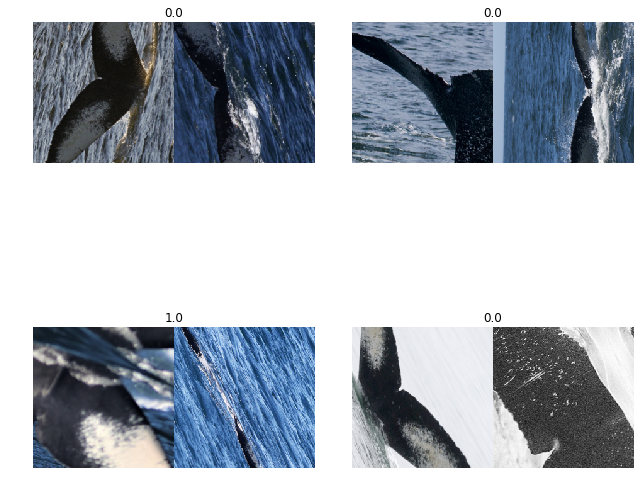

In [17]:
data.show_batch(2)

In [89]:
class SiameseNet(nn.Module):
    def __init__(self, arch=models.resnet18, lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.arch, self.emb_sz = arch, emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = learner.create_body(self.arch, True, learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body) * 2, self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
        
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [90]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() if size_average else losses.sum()

In [ ]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [92]:
model = SiameseNet()

In [94]:
create_cnn??

In [98]:
model = SiameseNet().cuda()
apply_init(model.head, nn.init.kaiming_normal_)
loss_func=ContrastiveLoss().cuda()
siam_learner = Learner(data, model, loss_func=loss_func) #,opt_func=AdamW

In [104]:
siam_learner.split(_resnet_split)

TypeError: 'SiameseNet' object does not support indexing

In [100]:
siam_learner.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace)
   (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


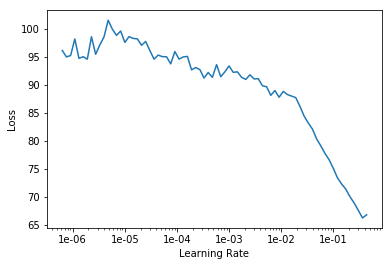

In [70]:
siam_learner.lr_find()
siam_learner.recorder.plot()

In [64]:
slice(1e-4, 1e-3, 1e-2)

slice(0.0001, 0.001, 0.01)

In [65]:
siam_learner.fit_one_cycle(5, slice(1e-4, 1e-3, 1e-2))

ZeroDivisionError: division by zero

In [ ]:
def extract_embedding(dl, ds, mdl):
    mdl.eval()
    with torch.no_grad():
        preds = torch.zeros((len(ds), 128))
        start=0
        for cnt, (x, y) in enumerate(dl, start=0):
            size = x[0].shape[0]
            preds[start:start+size,:] = model.get_embedding(x[0])
            start+= size
        return preds


In [ ]:
data = (SiamImageItemList.from_df(df=trn_imgs, path=path/'train', cols=0)
         .random_split_by_pct(valid_pct=1, seed=34)
         .label_from_df(cols=target_col, label_cls=FloatList)
         .transform(whl_tfms, size=224)
         .databunch(bs=4))

In [ ]:
dl = data.valid_dl
ds = data.valid_ds
res = extract_embedding(dl, ds, model)
whlc=np.array([trn_imgs.loc[trn_imgs.Image == Path(i).name, 'Id'].values[0] for i in ds.items])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [ ]:
pca.fit(res)
embs2d = pca.transform(res)

In [ ]:
import colorsys
def random_colors(N, bright=True):
    # This code is borrowed from https://github.com/matterport/Mask_RCNN
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def plot_embeddings(embeddings=None,whlc=None, xlim=None, ylim=None):
# This code is borrowed from https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb
    plt.figure(figsize=(10,10))
    for cnt, i in enumerate(set(whlc)):
#         print(cnt, i)
        inds = np.where(whlc==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[cnt])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(set(whlc))

In [ ]:
colors = random_colors(len(set(whlc)))
plot_embeddings(embs2d,whlc, xlim=None, ylim=None)